In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
16684,-122.8,38.2,36.0,2378.0,476.0,957.0,362.0,3.6,253100.0
12557,-121.7,37.9,19.0,2055.0,358.0,1064.0,350.0,4.7,263100.0
13406,-121.9,37.3,36.0,3142.0,632.0,1372.0,560.0,5.0,246100.0
5135,-118.1,34.2,49.0,1962.0,435.0,1329.0,457.0,3.3,200000.0
4592,-118.1,34.1,28.0,1778.0,605.0,2184.0,574.0,1.9,165900.0


In [0]:
def preprocess_features(california_housing_dataframe):
  
  selected_features = california_housing_dataframe[["latitude","longitude","housing_median_age", "total_rooms", "total_bedrooms", "population","households","median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])
  return processed_features

In [0]:
def preprocess_targets(california_housing_dataframe):
 
  output_targets = pd.DataFrame()
  # Create a boolean categorical feature representing whether the
  # median_house_value is above a set threshold.
  output_targets["median_house_value_is_high"] = (
    california_housing_dataframe["median_house_value"] > 265000).astype(float)
  return output_targets

In [0]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def get_quantile_based_buckets(feature_values, num_buckets):
  quantiles = feature_values.quantile([(i+1.)/(num_buckets + 1.) for i in range(num_buckets)])
  return [quantiles[q] for q in quantiles.keys()]

In [0]:
def construct_feature_columns():

  bucketized_households = tf.feature_column.bucketized_column(tf.feature_column.numeric_column("households"),
                                                              boundaries=get_quantile_based_buckets(training_examples["households"], 10))
  bucketized_longitude = tf.feature_column.bucketized_column(tf.feature_column.numeric_column("longitude"),
                                                             boundaries=get_quantile_based_buckets(training_examples["longitude"], 50))
  bucketized_latitude = tf.feature_column.bucketized_column(tf.feature_column.numeric_column("latitude"),
                                                            boundaries=get_quantile_based_buckets(training_examples["latitude"], 50))
  bucketized_housing_median_age = tf.feature_column.bucketized_column(tf.feature_column.numeric_column("housing_median_age"),
                                                                      boundaries=get_quantile_based_buckets(training_examples["housing_median_age"], 10))
  bucketized_total_rooms = tf.feature_column.bucketized_column(tf.feature_column.numeric_column("total_rooms"),
                                                               boundaries=get_quantile_based_buckets(training_examples["total_rooms"], 10))
  bucketized_total_bedrooms = tf.feature_column.bucketized_column(tf.feature_column.numeric_column("total_bedrooms"),
                                                                  boundaries=get_quantile_based_buckets(training_examples["total_bedrooms"], 10))
  bucketized_population = tf.feature_column.bucketized_column(tf.feature_column.numeric_column("population"),
                                                              boundaries=get_quantile_based_buckets(training_examples["population"], 10))
  bucketized_median_income = tf.feature_column.bucketized_column(tf.feature_column.numeric_column("median_income"),
                                                                 boundaries=get_quantile_based_buckets(training_examples["median_income"], 10))
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(tf.feature_column.numeric_column("rooms_per_person"),
                                                                    boundaries=get_quantile_based_buckets(training_examples["rooms_per_person"], 10))
  long_x_lat = tf.feature_column.crossed_column(set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)

  feature_columns = set([long_x_lat,bucketized_longitude,bucketized_latitude,bucketized_housing_median_age,bucketized_total_rooms,bucketized_total_bedrooms,
                         bucketized_population,bucketized_households,bucketized_median_income,bucketized_rooms_per_person])
  
  return feature_columns

In [0]:
def model_size(estimator):
  variables = estimator.get_variable_names()
  size = 0
  for variable in variables:
    if not any (x in variable for x in ['global_step','centered_bias_weight','bias_weight','Ftrl']):
      size += np.count_nonzero(estimator.get_variable_value(variable))

  return size

In [0]:
def train_linear_classifier_model(learning_rate,regularization_strength, steps, batch_size, feature_columns,training_examples, training_targets,
                                  validation_examples, validation_targets):

  periods = 7
  steps_per_period = steps / periods

  # Create a linear classifier object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate, l1_regularization_strength=regularization_strength)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples,  training_targets["median_house_value_is_high"], batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value_is_high"],  num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value_is_high"], num_epochs=1, shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on validation data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    # Compute training and validation loss.
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, validation_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

regularization value is 0.0
Training model...
LogLoss (on validation data):
  period 00 : 0.31
  period 01 : 0.28
  period 02 : 0.27
  period 03 : 0.26
  period 04 : 0.25
  period 05 : 0.25
  period 06 : 0.24
Model training finished.
Model size: 777


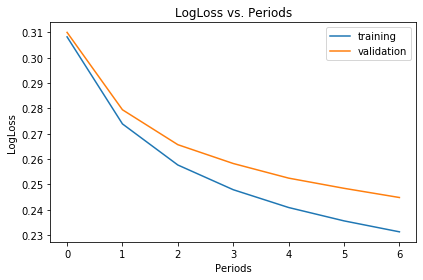

In [13]:
print("regularization value is 0.0")
linear_classifier = train_linear_classifier_model(0.1,0.0,300,100,construct_feature_columns(),training_examples,training_targets,validation_examples,validation_targets)
print("Model size:", model_size(linear_classifier))

regularization value is 0.4
Training model...
LogLoss (on validation data):
  period 00 : 0.33
  period 01 : 0.29
  period 02 : 0.27
  period 03 : 0.26
  period 04 : 0.26
  period 05 : 0.25
  period 06 : 0.25
Model training finished.
Model size: 663


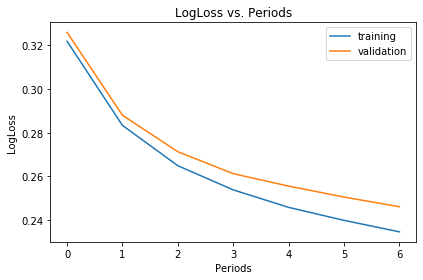

In [14]:
print("regularization value is 0.4")
linear_classifier = train_linear_classifier_model(0.1,0.4,300,100,construct_feature_columns(),training_examples,training_targets,validation_examples,validation_targets)
print("Model size:", model_size(linear_classifier))

regularization value is 0.8
Training model...
LogLoss (on validation data):
  period 00 : 0.33
  period 01 : 0.29
  period 02 : 0.28
  period 03 : 0.27
  period 04 : 0.26
  period 05 : 0.25
  period 06 : 0.25
Model training finished.
Model size: 579


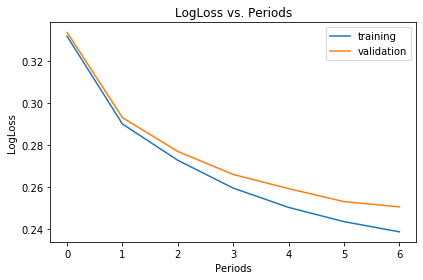

In [15]:
print("regularization value is 0.8")
linear_classifier = train_linear_classifier_model(0.1,0.8,300,100,construct_feature_columns(),training_examples,training_targets,validation_examples,validation_targets)
print("Model size:", model_size(linear_classifier))